In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import pathlib 
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

Using TensorFlow backend.


In [7]:
import tensorflow

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
width = 8
height = 8

In [3]:
def clear(img):
    """
    convert img to specific format (width,height) in RGB
    """
    if img.size != (width, height) :
        img = img.resize((width, height))
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img

In [4]:
labels = {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}

In [5]:
image_list, label_list = [], []

for folder in os.listdir('./raw_data'):
    for file in os.listdir('./raw_data/'+folder):
        img = Image.open('./raw_data/'+folder+'/'+file)
        img = clear(img)
        image_list.append(img_to_array(img))
        label_list.append(labels[folder])

X_train, X_test, y_train, y_test = train_test_split(image_list,
                                                    label_list,
                                                    test_size = 0.1,
                                                    random_state = 42,
                                                    stratify = label_list)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size = 0.1,
                                                  random_state = 42,
                                                  stratify = y_train)

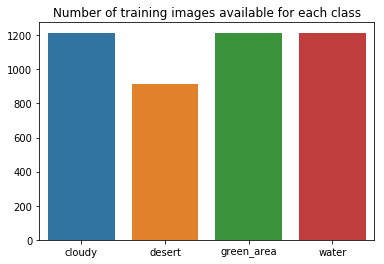

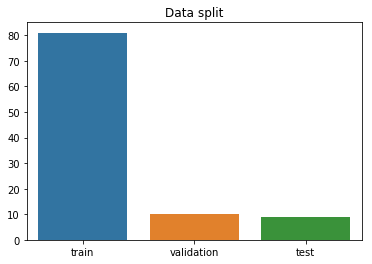

Total number of img in the dataset: 5631


In [6]:
label_names = ["cloudy","desert","green_area","water"]
unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x = label_names, y = counts )
plt.title('Number of training images available for each class')

plt.show()

data_type = ["train","validation","test"]
perc = [81,10,9]
sns.barplot(x = data_type, y = perc )
plt.title('Data split')

plt.show()

print("Total number of img in the dataset: 5631")

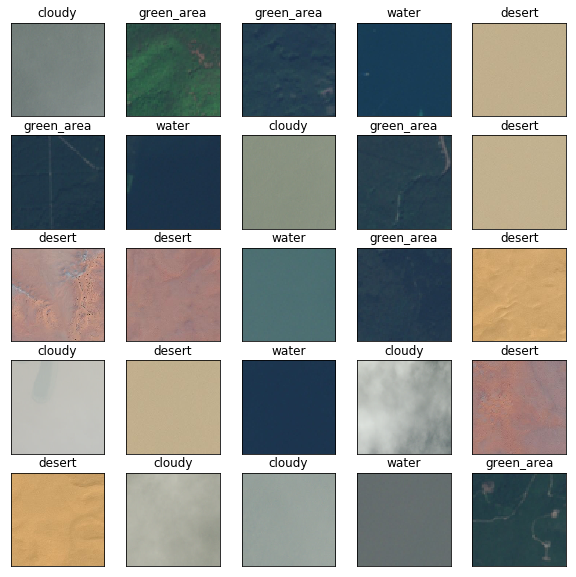

In [7]:
plt.figure(figsize=(10,10))
data_dir = pathlib.Path('./raw_data')
for i in range(25):
    plt.subplot(5,5,i+1)
    random_class = random.choice(label_names)
    img = plt.imread(random.choice(list(data_dir.glob(random_class+"/*.jpg"))))
    plt.xticks([])
    plt.yticks([])
    plt.title(random_class)
    plt.imshow(img)
plt.show()

In [8]:
X_train = np.array(X_train)/255
X_val = np.array(X_val)/255
X_test = np.array(X_test)/255

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

### CNN model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [65]:
model = Sequential()

model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'valid',input_shape=(width,height,3)))
model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'same'))

model.add(MaxPooling2D(2,2))
model.add(Flatten()) 

model.add(Dense(84,activation = 'sigmoid')) 
model.add(Dense(60,activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))  

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 3, 3, 20)          560       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 2, 2, 20)          3620      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 20)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 20)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 84)                1764      
_________________________________________________________________
dense_50 (Dense)             (None, 60)                5100      
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 244       
Total para

In [66]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=2,
    verbose=1)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr=0.005), metrics=['accuracy'])

epochs = 30

history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_val, y_val), callbacks = [callback])

Train on 4560 samples, validate on 507 samples
Epoch 1/30
4560/4560 [==============================] - 1s - loss: 0.6892 - acc: 0.6232 - val_loss: 0.5749 - val_acc: 0.7061
Epoch 2/30
4560/4560 [==============================] - 0s - loss: 0.4936 - acc: 0.7254 - val_loss: 0.5284 - val_acc: 0.7041
Epoch 3/30
4560/4560 [==============================] - 0s - loss: 0.4642 - acc: 0.7465 - val_loss: 0.4982 - val_acc: 0.7436
Epoch 4/30
4560/4560 [==============================] - 0s - loss: 0.4605 - acc: 0.7550 - val_loss: 0.4361 - val_acc: 0.7396
Epoch 5/30
4560/4560 [==============================] - 0s - loss: 0.4111 - acc: 0.8158 - val_loss: 0.3500 - val_acc: 0.8876
Epoch 6/30
4560/4560 [==============================] - 0s - loss: 0.3764 - acc: 0.8469 - val_loss: 0.4055 - val_acc: 0.7870
Epoch 7/30
4560/4560 [==============================] - 0s - loss: 0.3525 - acc: 0.8575 - val_loss: 0.3118 - val_acc: 0.8935
Epoch 8/30
4560/4560 [==============================] - 0s - loss: 0.3325 - ac

0.900709219013


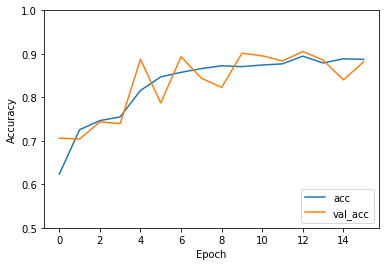

In [67]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)
plt.show()

In [10]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

In [11]:
space = {'lr' : hp.loguniform('lr', 0.0001, 0.01),
         'nb_epochs' :  50
        }

In [14]:
def f_nn(params):
    
    model = Sequential()

    model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'valid',input_shape=(width,height,3)))
    model.add(Conv2D(20,(3,3),strides = 2,activation = 'relu',padding = 'same'))

    model.add(MaxPooling2D(2,2))
    model.add(Flatten()) 

    model.add(Dense(84,activation = 'sigmoid')) 
    model.add(Dense(60,activation = 'relu'))
    model.add(Dense(4,activation = 'softmax'))  
    
    # callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=2, verbose=0)

    model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr=params['lr']), metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs = params['epochs'], validation_data = (X_val, y_val)) #, callbacks = [callback])

    pred_auc =model.predict_proba(X_val, batch_size = 128, verbose = 0)
    acc = roc_auc_score(y_val, pred_auc)
    print('AUC:', acc)
    sys.stdout.flush() 
    return {'loss': -acc, 'status': STATUS_OK}

In [15]:
trials = Trials()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=50, trials=trials)
print('best: ', best)

AttributeError: module 'numpy.random' has no attribute 'default_rng'

In [ ]:
from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Activation
    from keras.optimizers import Adadelta, Adam, rmsprop

    print ('Params testing: ', params)
    model = Sequential()
    model.add(Dense(output_dim=params['units1'], input_dim = X.shape[1])) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout1']))

    model.add(Dense(output_dim=params['units2'], init = "glorot_uniform")) 
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout2']))

    if params['choice']['layers']== 'three':
        model.add(Dense(output_dim=params['choice']['units3'], init = "glorot_uniform")) 
        model.add(Activation(params['activation']))
        model.add(Dropout(params['choice']['dropout3']))    

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'])

    model.fit(X, y, nb_epoch=params['nb_epochs'], batch_size=params['batch_size'], verbose = 0)

In [68]:
!pip install hyperopt

  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: C:\Users\eloua\AppData\Local\pip\Cache\wheels\8b\99\a0\81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: decorator 4.1.2
    Uninstalling decorator-4.1.2:
      Successfully uninstalled decorator-4.1.2
  Found existing installation: networkx 2.0
    Uninstalling networkx-2.0:
      Successfully uninstalled networkx-2.0


You are using pip version 9.0.1, however version 22.1.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [18]:
!pip install numpy --upgrade

  Found existing installation: numpy 1.13.3+mkl
    Uninstalling numpy-1.13.3+mkl:
      Successfully uninstalled numpy-1.13.3+mkl


Exception:
Traceback (most recent call last):
  File "C:\Users\eloua\OneDrive\Bureau\Python\python-3.6.3.amd64\lib\shutil.py", line 387, in _rmtree_unsafe
    os.unlink(fullname)
PermissionError: [WinError 5] Access is denied: 'C:\\Users\\eloua\\AppData\\Local\\Temp\\pip-ejrv__eh-uninstall\\users\\eloua\\onedrive\\bureau\\python\\python-3.6.3.amd64\\lib\\site-packages\\numpy\\core\\libifcoremd.dll'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\eloua\OneDrive\Bureau\Python\python-3.6.3.amd64\lib\site-packages\pip\basecommand.py", line 215, in main
    status = self.run(options, args)
  File "C:\Users\eloua\OneDrive\Bureau\Python\python-3.6.3.amd64\lib\site-packages\pip\commands\install.py", line 342, in run
    prefix=options.prefix_path,
  File "C:\Users\eloua\OneDrive\Bureau\Python\python-3.6.3.amd64\lib\site-packages\pip\req\req_set.py", line 795, in install
    requirement.commit_uninstall()
  File "C:\Users